# Preprocessing and Baselines

### Notebook Goals:
In this notebook, we prepare the data for modeling and train baseline models to establish a benchmark for churn predictions.

### Load Data and Initial Cleanup

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/raw/telco_churn.csv")

In [3]:
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
df.drop(columns=["customerID"], inplace=True)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.fillna(0)
df["Churn"] = df["Churn"].astype("int")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


### Train/Test Split
We split this dataset into training and test sets using stratified sampling to preserve the original churn distribution.This ensures reliable performance evaluation on an imbalanced target variable.

In [5]:
y = df["Churn"]
X = df.drop(columns=["Churn"])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Feature Encoding Stategy
Categorical Values are encoded using one-hot encoding to avoid imposing ordinal relationships. Numerical Values are scaled using standardization.All preprocessing steps are fit to exclusively on the training data and applied to the test data to prevent leakage.

In [7]:
categorical_features = list(X_train.select_dtypes(include=["object"]).columns)
numerical_features = list(X_train.select_dtypes(include=["int64", "float64"]).columns)

numerical_features.remove("SeniorCitizen")
categorical_features.append("SeniorCitizen")



print("Categorical columns:", categorical_features)
print("Numerical columns:", numerical_features)

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
Numerical columns: ['tenure', 'MonthlyCharges', 'TotalCharges']


Although SeniorCitizen is numerically encoded, it represents a binary category and should be a Categorical Feature

### Preprocessing Pipeline
We construct a pipeline using a ColumnTransformer to apply one hot encoding to categorical features and standardization to numerical features.This pipeline fits exclusively on the training data to prevent data leakage

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [9]:
numerical_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [11]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(
            class_weight="balanced",
            max_iter=1000,
            random_state=42
        ))
    ]
)

In [12]:
pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

### Baseline Models

#### Logistic Regression
We use Logistic Regression for this problem because Churn is a binary outcome(Yes/No) and the model produces probability estimates, which are important for business decision-making and ranking customers by churn risk.

In [13]:
from sklearn.linear_model import LogisticRegression
# Full pipeline: preprocessing + model
log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

# Fit on raw training data
log_reg_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

We configured the model with the following considerations:
* Class imbalance handling: The dataset contains significantly more non-churners than churners. To address this, we use `class_weight="balanced"`, which penalizes misclassification of the minority class (churners) more heavily.
* Model convergence: `max_iter=1000` ensures the optimization process converges reliably.
* Reproducibility: A fixed `random_state` is used so results can be consistently reproduced.

In [14]:
y_pred = log_reg_pipeline.predict(X_test)
y_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

After training, we generate two types of outputs:
Predicted class labels (0 or 1), which indicate whether the model classifies a customer as a churner.
Predicted churn probabilities, which represent the model’s confidence that a customer will churn.

In [15]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC AUC Score: 0.841501976284585


We evaluate the baseline model using two complementary metrics:
* Classification report, which summarizes precision, recall, and F1-score for both churners and non-churners.
* ROC-AUC score, which measures how well the model ranks churners above non-churners across all possible classification thresholds.

ROC-AUC is particularly appropriate for this problem because it is threshold-independent and robust to class imbalance. A higher ROC-AUC indicates better separation between churners and non-churners in terms of predicted churn risk.

#### Feature Interpretation

In [16]:
preprocessor = pipeline.named_steps["preprocessor"]

cat_features = preprocessor.named_transformers_["cat"] \
    .named_steps["onehot"] \
    .get_feature_names_out(categorical_features)

feature_names = np.concatenate([numerical_features, list(cat_features)])

In [17]:
coefficients = pipeline.named_steps["classifier"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

In [18]:
coef_df["abs_coefficient"] = coef_df["Coefficient"].abs()
coef_df_sorted = coef_df.sort_values(by="abs_coefficient", ascending=False)
coef_df_sorted.head(25)

,Feature,Coefficient,abs_coefficient
0,tenure,-1.141091,1.141091
37,Contract_Two year,-0.766446,0.766446
15,InternetService_Fiber optic,0.715756,0.715756
1,MonthlyCharges,-0.677256,0.677256
35,Contract_Month-to-month,0.662997,0.662997
14,InternetService_DSL,-0.617657,0.617657
2,TotalCharges,0.474357,0.474357
34,StreamingMovies_Yes,0.282577,0.282577
21,OnlineBackup_No internet service,-0.270347,0.270347
16,InternetService_No,-0.270347,0.270347


##### Feature Importance
The most influential feature reducing churn is customer tenure,indicating that long-term customers are significantly less likely to leave.Contract type also plays a major role, with two year contracts strongly reducing churn while month-to-month contracts increase churn risk.

 Among service-related features, fiber-optic internet is associated with higher churn,while DSL and no internet service customers churn less.Payment behavior also matter. with electronic check users showing elevated churn risk.

These findings are consistent with the patterns observed during EDA and provide interpretable drivers of churn behavior.


#### RandomForest
We trained and evaluated a Random Forest classifier as a more expressive, non-linear model for predicting customer churn. Since Random Forests are ensemble, tree-based models that can naturally capture nonlinear relationships and feature interactions that simpler models(Logistic Regression) might miss.

In [19]:
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    drop="first"
)

numerical_transformer = "passthrough"

In [20]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

##### Model Pipeline
Here we used a single end-to-end pipeline that includes:
* Preprocessing
    * Numerical features scaled using `StandardScaler`
    * Categorical features encoded using `OneHotEncoder`
* Model
    * `RandomForestClassifier` with class balancing to account for churn imbalance

This pipeline ensures that all preprocessing steps are learned only from the training data and consistently applied to the test data, preventing data leakage.

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)

In [22]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_rf),
    ("model", rf_model)
])
rf_pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [23]:
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

##### Model Training

The pipeline was fit on the training set (`X_train`, `y_train`) and evaluated on the held-out test set. Predictions and predicted probabilities were generated using:
* `predict()` for class labels
* `predict_proba()` for churn probabilities

In [24]:
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_rf))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1035
           1       0.57      0.67      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.78      1409

ROC AUC Score: 0.8377819111834458


##### Classification Report
* __Recall for churners (67%)__ indicates the model successfully identifies a majority of customers who actually churn.
* __Precision for churners (57%)__ reflects a trade-off where some non-churners are flagged as churners, which is often acceptable in churn prevention scenarios.
* __Accuracy (78%)__ is reported for completeness, but is less informative due to class imbalance.

##### ROC_AUC Score
The ROC-AUC score measures the model’s ability to **rank churners higher than non-churners** based on predicted probabilities.
An ROC-AUC of **0.84** indicates strong discriminative performance and represents an improvement over the Logistic Regression baseline.

#### Threshold Optimization for Churn Prediction
##### Why This Matters
A default probability threshold of 0.5 is not necessarily optimal for churn prediction. While the model outputs probabilities of churn, the threshold determines how those probabilities are converted into binary decisions. Choosing 0.5 is arbitrary and may not align with business objectives.

In churn prediction, recall for the churn class is more important than precision. Missing a customer who is likely to churn (a false negative) is typically more costly than incorrectly flagging a customer who would have stayed. Therefore, the model should prioritize correctly identifying churners, even if it results in more false positives.

This section analyzes how different probability thresholds affect model performance and explores how adjusting the threshold can better align predictions with business priorities.


#### Baseline Performance at Default Threshold

In [25]:
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

In [26]:
thresholds = np.arange(0.1,0.9,0.1)


In [28]:
from sklearn.metrics import precision_score, recall_score
results = []

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    results.append({
        "Threshold": threshold,
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
    })

results_df = pd.DataFrame(results)
results_df

,Threshold,Precision,Recall
0,0.1,0.352998,0.975936
1,0.2,0.416058,0.914439
2,0.3,0.475976,0.847594
3,0.4,0.526882,0.786096
4,0.5,0.568849,0.673797
5,0.6,0.631098,0.553476
6,0.7,0.705607,0.403743
7,0.8,0.767857,0.229947


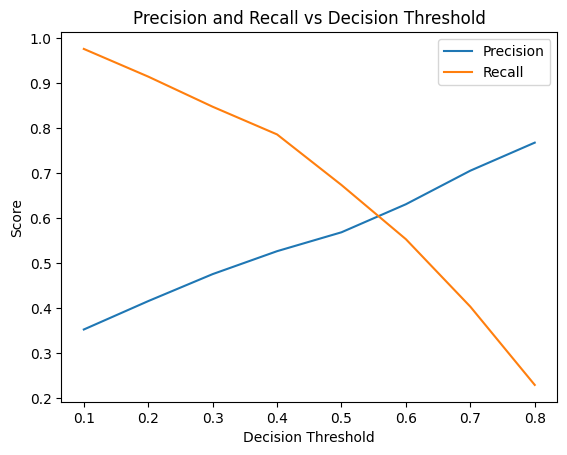

In [32]:
import matplotlib.pyplot as plt
plt.plot(results_df["Threshold"], results_df["Precision"], label="Precision")
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall")

plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Decision Threshold")
plt.legend()
plt.show()

#### Precision-Recall Tradeoff Across Thresholds

#### Business Driven Threshold Selection

#### Final Threshold Evaluation